# Purpose

2022-07(update):
Check more params to see if there are some parameters we can exclude (because they always result in outputs with low performance).

Parmeters to check:
- cluster_linkage
- distance metric (`cluster__affinity`)
- SVD step (apply SVD before clustering)

---
2022-02
After fixing the parallel jobs, we need to pick the best model to share on bigQuery and to use for new FPRs.


# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import logging
import os
from pathlib import Path

import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns

import mlflow
import hydra

import subclu
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils import set_working_directory, get_project_subfolder
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl, 
    get_color_dict, base_colors_for_manual_labels,
    check_colors_used,
)
from subclu.data.data_loaders import LoadPosts, LoadSubreddits, create_sub_level_aggregates


# ===
# imports specific to this notebook



print_lib_versions([hydra, np, pd, plotly, sns, subclu])

python		v 3.7.10
===
hydra		v: 1.1.0
numpy		v: 1.19.5
pandas		v: 1.2.4
plotly		v: 4.14.3
seaborn		v: 0.11.1
subclu		v: 0.5.0


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Set sqlite database as MLflow URI

In [4]:
# use new class to initialize mlflow
mlf = MlflowLogger(tracking_uri='sqlite')
mlflow.get_tracking_uri()

'sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db'

## Get list of experiments with new function

In [5]:
mlf.list_experiment_meta(output_format='pandas').tail(9)

,experiment_id,name,artifact_location,lifecycle_stage
25,25,v0.4.1_mUSE_clustering_new_metrics,gs://i18n-subreddit-clustering/mlflow/mlruns/25,active
26,26,v0.4.1_nearest_neighbors_test,gs://i18n-subreddit-clustering/mlflow/mlruns/26,active
27,27,v0.4.1_nearest_neighbors,gs://i18n-subreddit-clustering/mlflow/mlruns/27,active
28,28,v0.5.0_mUSE_aggregates_test,gs://i18n-subreddit-clustering/mlflow/mlruns/28,active
29,29,v0.5.0_mUSE_aggregates,gs://i18n-subreddit-clustering/mlflow/mlruns/29,active
30,30,v0.5.0_mUSE_clustering_test,gs://i18n-subreddit-clustering/mlflow/mlruns/30,active
31,31,v0.5.0_mUSE_clustering,gs://i18n-subreddit-clustering/mlflow/mlruns/31,active
32,32,v0.5.0_nearest_neighbors_test,gs://i18n-subreddit-clustering/mlflow/mlruns/32,active
33,33,v0.5.0_nearest_neighbors,gs://i18n-subreddit-clustering/mlflow/mlruns/33,active


## Get experiment ID's for models to check

experiment ID 25 as the latest runs

In [6]:
%%time

df_mlf = mlf.search_all_runs(experiment_ids=[25])
df_mlf.shape

CPU times: user 1.37 s, sys: 74.2 ms, total: 1.44 s
Wall time: 1.44 s


(132, 273)

In [7]:
df_mlf.iloc[:5, :10]

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.primary_topic-2700_to_3000-f1_score-weighted_avg,metrics.primary_topic-0100_to_0250-recall-weighted_avg,metrics.primary_topic-1350_to_1700-adjusted_rand_score,metrics.optimal_k-0020_to_0040
0,a6ee2f75491d4449a05fad502d7b80c3,25,FINISHED,gs://i18n-subreddit-clustering/mlflow/mlruns/25/a6ee2f75491d4449a05fad502d7b80c3/artifacts,2022-01-20 19:50:19.553000+00:00,2022-01-20 19:54:40.237000+00:00,0.374614,0.393622,0.393536,21.0
1,4b246da72d254bf9888962d483ed49a3,25,FINISHED,gs://i18n-subreddit-clustering/mlflow/mlruns/25/4b246da72d254bf9888962d483ed49a3/artifacts,2022-01-20 19:49:26.745000+00:00,2022-01-20 20:02:40.384000+00:00,0.607131,0.264930,0.174290,22.0
2,619e29db458a43e6ac726eac7145db89,25,FINISHED,gs://i18n-subreddit-clustering/mlflow/mlruns/25/619e29db458a43e6ac726eac7145db89/artifacts,2022-01-20 19:49:09.043000+00:00,2022-01-20 19:53:31.024000+00:00,0.377043,0.386889,0.388680,22.0
3,25c5dfaa03d34da88fdfb3a1850d7d44,25,FINISHED,gs://i18n-subreddit-clustering/mlflow/mlruns/25/25c5dfaa03d34da88fdfb3a1850d7d44/artifacts,2022-01-20 19:48:44.509000+00:00,2022-01-20 20:02:25.618000+00:00,0.601132,0.265050,0.186013,22.0
4,b29776a461994e00b00139ec1bb6270b,25,FINISHED,gs://i18n-subreddit-clustering/mlflow/mlruns/25/b29776a461994e00b00139ec1bb6270b/artifacts,2022-01-20 19:46:49.578000+00:00,2022-01-20 19:51:15.689000+00:00,0.370385,0.390176,0.394354,26.0


In [8]:
mask_finished = df_mlf['status'] == 'FINISHED'
mask_df_similarity_complete = ~df_mlf['metrics.primary_topic-2350_to_2700-f1_score-weighted_avg'].isnull()

df_mlf_clustering_candidates = df_mlf[mask_finished & mask_df_similarity_complete]
df_mlf_clustering_candidates.shape

(132, 273)

In [9]:
cols_with_multiple_vals = df_mlf_clustering_candidates.columns[df_mlf_clustering_candidates.nunique(dropna=False) > 1]
print(f"interesting cols: {len(cols_with_multiple_vals)}")
df_mlf_clustering_candidates[cols_with_multiple_vals].iloc[:5, :10]

interesting cols: 244


,run_id,artifact_uri,start_time,end_time,metrics.primary_topic-2700_to_3000-f1_score-weighted_avg,metrics.primary_topic-0100_to_0250-recall-weighted_avg,metrics.primary_topic-1350_to_1700-adjusted_rand_score,metrics.optimal_k-0020_to_0040,metrics.primary_topic-0040_to_0050-f1_score-weighted_avg,metrics.primary_topic-3900_to_4000-adjusted_rand_score
0,a6ee2f75491d4449a05fad502d7b80c3,gs://i18n-subreddit-clustering/mlflow/mlruns/25/a6ee2f75491d4449a05fad502d7b80c3/artifacts,2022-01-20 19:50:19.553000+00:00,2022-01-20 19:54:40.237000+00:00,0.374614,0.393622,0.393536,21.0,0.266083,0.435572
1,4b246da72d254bf9888962d483ed49a3,gs://i18n-subreddit-clustering/mlflow/mlruns/25/4b246da72d254bf9888962d483ed49a3/artifacts,2022-01-20 19:49:26.745000+00:00,2022-01-20 20:02:40.384000+00:00,0.607131,0.264930,0.174290,22.0,0.110795,0.552732
2,619e29db458a43e6ac726eac7145db89,gs://i18n-subreddit-clustering/mlflow/mlruns/25/619e29db458a43e6ac726eac7145db89/artifacts,2022-01-20 19:49:09.043000+00:00,2022-01-20 19:53:31.024000+00:00,0.377043,0.386889,0.388680,22.0,0.286060,0.431899
3,25c5dfaa03d34da88fdfb3a1850d7d44,gs://i18n-subreddit-clustering/mlflow/mlruns/25/25c5dfaa03d34da88fdfb3a1850d7d44/artifacts,2022-01-20 19:48:44.509000+00:00,2022-01-20 20:02:25.618000+00:00,0.601132,0.265050,0.186013,22.0,0.110861,0.554140
4,b29776a461994e00b00139ec1bb6270b,gs://i18n-subreddit-clustering/mlflow/mlruns/25/b29776a461994e00b00139ec1bb6270b/artifacts,2022-01-20 19:46:49.578000+00:00,2022-01-20 19:51:15.689000+00:00,0.370385,0.390176,0.394354,26.0,0.288908,0.427043


# EDA parameters to check

Parmeters to check:
- cluster_linkage (`params._pipe-cluster__linkage`)
- distance metric (`params._pipe-cluster__affinity`)
- SVD step (apply SVD before clustering)
    - `params._pipe-reduce__n_components` (`Null` or `None` => No SVD reduction)
    
Note: `Normalize l2` is only applied to `ward` because:
- `l2-norm+euclidean distance = cosine distance`
`sklearn`'s implementation of `ward` only works with cosine distance, so we need to make this tweak in order to get cosine distance (which is better for our use case).

---
Note 2:
It looks like there is a but in the `SVD` / Reduction step because `n_components` always equals 2.  It should be `50`.

In [35]:
# [c for c in df_mlf_clustering_candidates.columns if 'norm' in c]

In [34]:
# [c for c in df_mlf_clustering_candidates.columns if 'min' in c]

In [128]:
l_parallel_params = [
    # 'metrics.filtered_embeddings-n_rows',  # Might not be a parameter to tune anymore (n_minimumn # of posts in subreddit)
    'params._pipe-normalize__norm', 
    'params._pipe-reduce__n_components',
    'params._pipe-cluster__affinity',
    'params._pipe-cluster__linkage',

]

for c_ in l_parallel_params:
    display(
        value_counts_and_pcts(
            df_mlf_clustering_candidates,
            [c_]
        )
    )

,count,percent,cumulative_percent
params._pipe-normalize__norm,,,
null,114,86.4%,86.4%
l2,18,13.6%,100.0%


,count,percent,cumulative_percent
params._pipe-reduce__n_components,,,
2,66,50.0%,50.0%
null,66,50.0%,100.0%


,count,percent,cumulative_percent
params._pipe-cluster__affinity,,,
euclidean,84,63.6%,63.6%
cosine,48,36.4%,100.0%


,count,percent,cumulative_percent
params._pipe-cluster__linkage,,,
ward,36,27.3%,27.3%
average,32,24.2%,51.5%
complete,32,24.2%,75.8%
single,32,24.2%,100.0%


In [129]:
d_linkage_to_num = {
    'ward': 4,
    'average': 3,
    'complete': 2,
    'single': 1,
}
d_num_to_linkage = {v: k for k, v in d_linkage_to_num.items()}
print(d_num_to_linkage)

d_affinity_to_num = {
    'cosine': 2,
    'euclidean': 1,
}
d_num_to_affinity = {v: k for k, v in d_affinity_to_num.items()}
print(d_num_to_affinity)

d_norm_to_num = {
    'l2': 2,
    'None': 1,
}
d_num_to_norm = {v: k for k, v in d_norm_to_num.items()}
print(d_num_to_norm)

d_comp_to_num = {
    "None": 512,
    2: 2,
    50: 50
}
d_num_to_comp = {v: k for k, v in d_comp_to_num.items()}
print(d_num_to_comp)

{4: 'ward', 3: 'average', 2: 'complete', 1: 'single'}
{2: 'cosine', 1: 'euclidean'}
{2: 'l2', 1: 'None'}
{512: 'None', 2: 2, 50: 50}


In [130]:
value_counts_and_pcts(
    df_mlf_clustering_candidates,
    l_parallel_params
)

In [131]:
# l_all_pipe_params = sorted([c for c in df_mlf_clustering_candidates.columns if 'params._pipe' in c])
# df_mlf_clustering_candidates[l_all_pipe_params].head()

In [152]:
# sorted([c for c in df_mlf_clustering_candidates.columns if 'distance' in c])

# Pick primary metric cols for evaluation & visualize in parallel coordinates plot

We want to keep the model that:
- has the highest metric scores
- covers the largest number of subreddits (rows)

One hyperparameter while creating clusters is filtering out subreddits with too few posts (min posts). Sometimes these can add noise and impact clustering upstream.

params:
- linkage type
- number of subreddits (rows) after filtering
 
metrics:
- Optimal clusters to check:
    - @ 3000 to 3200
    - @ 3900 to 4000
- metrics
    - f1 weighted
    - adjusted mutual info
    - adjusted rand score
    - homogeneity

In [133]:
def rename_col_for_display(
    col_name: str,
) -> str:
    """
    Remove prefixes & other extra characters to columns so 
    that it's easier to read/display them in plots & tables
    """
    return (
        col_name
        .replace('metrics.primary_topic-', '')
        .replace('00-', '00<br>')  # split cols into 2 rows after num of clusters (k)
        .replace('filtered_embeddings-n_rows', 'subreddits')  # subreddits clustered
        .replace('_score', '_score<br>') # add an extra break after avg & score to improve look of plots
        .replace('_avg', '_avg<br><br>')
        .replace('metrics.', '')
        .replace('params.', '')
        .replace('_pipe-', '')
        .replace('__', '_')
        .replace('_', ' ')
    )

In [134]:
sorted([rename_col_for_display(c) for c in l_parallel_params])

['cluster affinity',
 'cluster linkage',
 'normalize norm',
 'reduce n components']

In [135]:
# sorted([c for c in df_mlf_clustering_candidates.columns if '3000' in c])

In [136]:
# sorted([c for c in df_mlf_clustering_candidates.columns if '4000' in c])

In [137]:
# sorted([rename_col_for_display(c) for c in df_mlf_clustering_candidates.columns if '4000' in c])

In [138]:
# [c for c in df_mlf_clustering_candidates.columns if 'metric' in c][-15:]

For now forget linkage type, there's some weird thing where you can't show text or category dtypes in a parallel coordinate plot (unless you convert the values to numbers).
- https://github.com/plotly/plotly.py/issues/2494

Looks like you could use the lower-level `go.Parcoords` to do it, but at this point that's too much for me (maybe this is what mlflow uses under the hood?).
- https://plotly.com/python/parallel-coordinates-plot/#parallel-coordinates-chart-with-goparcoords


---
NOTE: plotly uses a df's index, so make sure to reset index b/c otherwise we can end up with weird results!

In [139]:

l_parallel_metrics_3k = [
    # 'metrics.primary_topic-3000_to_3200-homogeneity_score',
    'metrics.primary_topic-3000_to_3200-adjusted_mutual_info_score',
    # 'metrics.primary_topic-3000_to_3200-adjusted_rand_score',
    'metrics.primary_topic-3000_to_3200-f1_score-weighted_avg',
]
l_parallel_metrics_4k = [
    # 'metrics.primary_topic-3900_to_4000-homogeneity_score',
    'metrics.primary_topic-3900_to_4000-adjusted_mutual_info_score',
    # 'metrics.primary_topic-3900_to_4000-adjusted_rand_score',
    'metrics.primary_topic-3900_to_4000-f1_score-weighted_avg',
]

l_parallel_metrics_all = l_parallel_metrics_3k + l_parallel_metrics_4k

Linkage names:
  {4: 'ward', 3: 'average', 2: 'complete', 1: 'single'}
Affinity names:
  {2: 'cosine', 1: 'euclidean'}
Component names:
  {512: 'None', 2: 2, 50: 50}
Norm names:
  {2: 'l2', 1: 'None'}


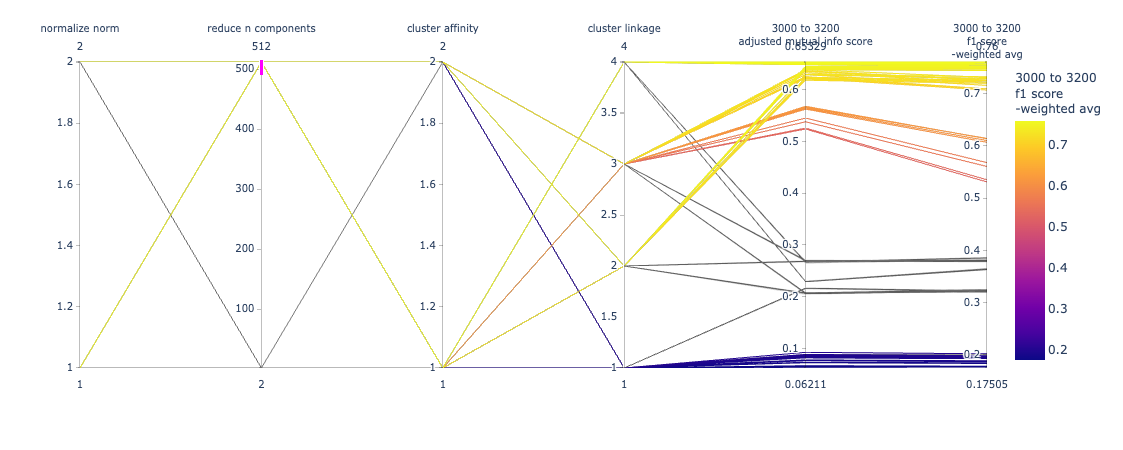

In [140]:
l_cols_plot_raw_ = l_parallel_params + l_parallel_metrics_3k
l_cols_plot_clean_ = [rename_col_for_display(c) for c in l_cols_plot_raw_]
df_plot_ = (
    df_mlf_clustering_candidates[l_cols_plot_raw_]
    .fillna({'params._pipe-reduce__n_components': 512, 'params._pipe-normalize__norm': 'None'})  # for SVD nulls & norm nulls
    .rename(columns={c: rename_col_for_display(c) for c in l_cols_plot_raw_})
    .reset_index(drop=True)
)
# remap cluster linkage so it shows up in plot
col_linkage_clean = 'cluster linkage'
col_affinity_clean = 'cluster affinity'
col_comp_clean = 'reduce n components'
col_norm_clean = 'normalize norm'
df_plot_[col_linkage_clean] = df_plot_[col_linkage_clean].replace(d_linkage_to_num)
df_plot_[col_affinity_clean] = df_plot_[col_affinity_clean].replace(d_affinity_to_num)
df_plot_[col_comp_clean] = df_plot_[col_comp_clean].astype(int).replace(d_comp_to_num)
df_plot_[col_norm_clean] = df_plot_[col_norm_clean].replace(d_norm_to_num)
print(f"Linkage names:\n  {d_num_to_linkage}")
print(f"Affinity names:\n  {d_num_to_affinity}")
print(f"Component names:\n  {d_num_to_comp}")
print(f"Norm names:\n  {d_num_to_norm}")

fig = px.parallel_coordinates(
    df_plot_,
    color=l_cols_plot_clean_[-1],
    # dimensions=l_cols_plot_clean_,
    # labels={},
    # color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=2
)
fig.show()

Plot w/o normalized norm (it only changes `ward` linkage)

Linkage names:
  {4: 'ward', 3: 'average', 2: 'complete', 1: 'single'}
Affinity names:
  {2: 'cosine', 1: 'euclidean'}
Component names:
  {512: 'None', 2: 2, 50: 50}


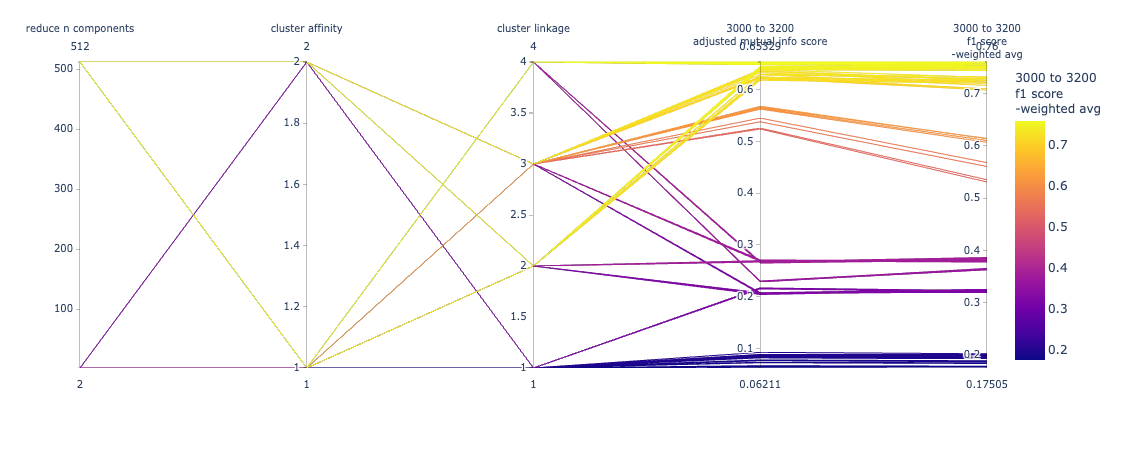

In [153]:
l_cols_plot_raw_ = l_parallel_params + l_parallel_metrics_3k
l_cols_plot_clean_ = [rename_col_for_display(c) for c in l_cols_plot_raw_]
df_plot_ = (
    df_mlf_clustering_candidates[l_cols_plot_raw_]
    .fillna({'params._pipe-reduce__n_components': 512})  # for SVD nulls
    .rename(columns={c: rename_col_for_display(c) for c in l_cols_plot_raw_})
    .reset_index(drop=True)
)
# remap cluster linkage so it shows up in plot
col_linkage_clean = 'cluster linkage'
col_affinity_clean = 'cluster affinity'
col_comp_clean = 'reduce n components'
df_plot_[col_linkage_clean] = df_plot_[col_linkage_clean].replace(d_linkage_to_num)
df_plot_[col_affinity_clean] = df_plot_[col_affinity_clean].replace(d_affinity_to_num)
df_plot_[col_comp_clean] = df_plot_[col_comp_clean].astype(int).replace(d_comp_to_num)
print(f"Linkage names:\n  {d_num_to_linkage}")
print(f"Affinity names:\n  {d_num_to_affinity}")
print(f"Component names:\n  {d_num_to_comp}")

# df_plot_ = df_plot_.drop('subreddits', axis=1)
fig = px.parallel_coordinates(
    df_plot_,
    color=l_cols_plot_clean_[-1],
    # dimensions=l_cols_plot_clean_,
    # labels={},
    # color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=2
)
fig.show()

Check score at k=4000m

Linkage names:
  {4: 'ward', 3: 'average', 2: 'complete', 1: 'single'}
Affinity names:
  {2: 'cosine', 1: 'euclidean'}
Component names:
  {512: 'None', 2: 2, 50: 50}


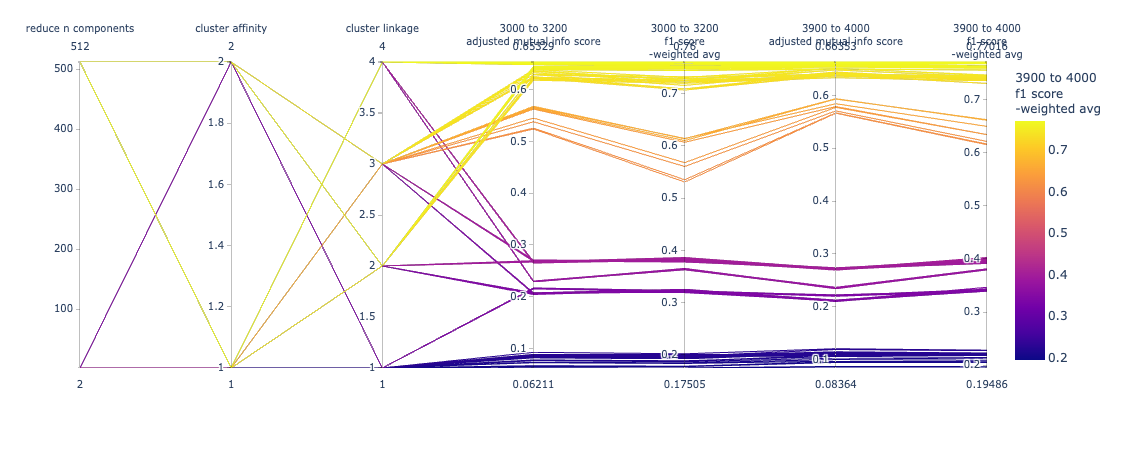

In [148]:
l_cols_plot_raw_ = l_parallel_params + l_parallel_metrics_3k + l_parallel_metrics_4k
l_cols_plot_clean_ = [rename_col_for_display(c) for c in l_cols_plot_raw_]
df_plot_ = (
    df_mlf_clustering_candidates[l_cols_plot_raw_]
    .fillna({'params._pipe-reduce__n_components': 512})  # for SVD nulls
    .rename(columns={c: rename_col_for_display(c) for c in l_cols_plot_raw_})
    .reset_index(drop=True)
)
# remap cluster linkage so it shows up in plot
col_linkage_clean = 'cluster linkage'
col_affinity_clean = 'cluster affinity'
col_comp_clean = 'reduce n components'
df_plot_[col_linkage_clean] = df_plot_[col_linkage_clean].replace(d_linkage_to_num)
df_plot_[col_affinity_clean] = df_plot_[col_affinity_clean].replace(d_affinity_to_num)
df_plot_[col_comp_clean] = df_plot_[col_comp_clean].astype(int).replace(d_comp_to_num)
print(f"Linkage names:\n  {d_num_to_linkage}")
print(f"Affinity names:\n  {d_num_to_affinity}")
print(f"Component names:\n  {d_num_to_comp}")


fig = px.parallel_coordinates(
    df_plot_,
    color=l_cols_plot_clean_[-1],
    # dimensions=l_cols_plot_clean_,
    # labels={},
    # color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=2
)
fig.show()

## Exclude runs with `single linkage` b/c they're the worst ones

Can we see other params to exclude by removing noise from `single linkage`?

remember to `.reset_index()` after flintering (before plotting)!

Linkage names:
  {4: 'ward', 3: 'average', 2: 'complete', 1: 'single'}
Affinity names:
  {2: 'cosine', 1: 'euclidean'}
Component names:
  {512: 'None', 2: 2, 50: 50}


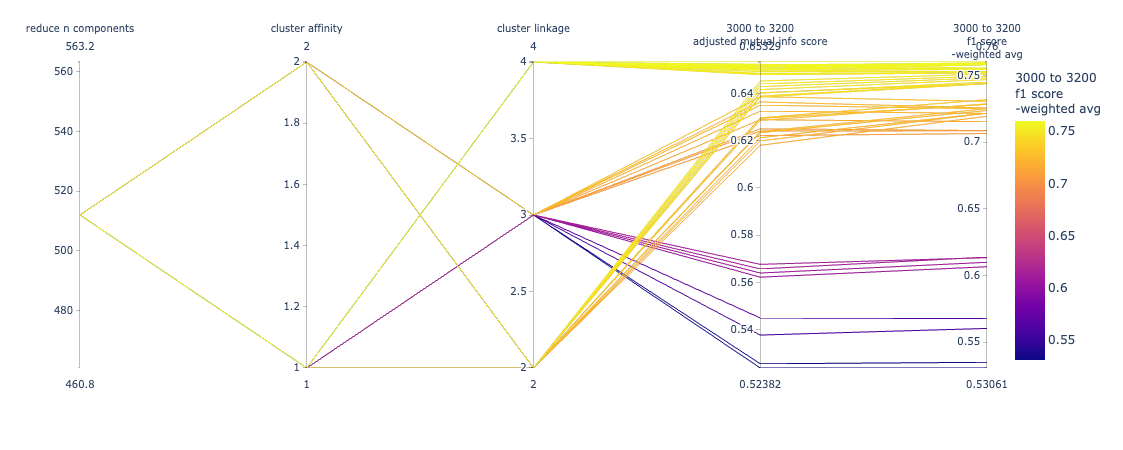

,3000 to 3200<br>adjusted mutual info score<br>,3000 to 3200<br>f1 score<br>-weighted avg<br><br>
cluster linkage,,
2,0.632847,0.735748
3,0.589653,0.648626
4,0.650589,0.756033


In [187]:
l_cols_plot_raw_ = l_parallel_params + l_parallel_metrics_3k
l_cols_plot_clean_ = [rename_col_for_display(c) for c in l_cols_plot_raw_]
df_plot_ = (
    df_mlf_clustering_candidates
    [l_cols_plot_raw_]
    .fillna({'params._pipe-reduce__n_components': 512, 'params._pipe-normalize__norm': 'None'})  # for SVD nulls & norm nulls
    .rename(columns={c: rename_col_for_display(c) for c in l_cols_plot_raw_})
    .reset_index(drop=True)
    .copy()
)
# remap cluster linkage so it shows up in plot
col_linkage_clean = 'cluster linkage'
col_affinity_clean = 'cluster affinity'
col_comp_clean = 'reduce n components'

df_plot_[col_linkage_clean] = df_plot_[col_linkage_clean].replace(d_linkage_to_num)
df_plot_[col_affinity_clean] = df_plot_[col_affinity_clean].replace(d_affinity_to_num)
df_plot_[col_comp_clean] = df_plot_[col_comp_clean].astype(int).replace(d_comp_to_num)
print(f"Linkage names:\n  {d_num_to_linkage}")
print(f"Affinity names:\n  {d_num_to_affinity}")
print(f"Component names:\n  {d_num_to_comp}")

# apply filters
df_plot_ = df_plot_[df_plot_[col_linkage_clean] != d_linkage_to_num['single']].reset_index(drop=True)
df_plot_ = df_plot_[df_plot_[col_comp_clean] != 2].reset_index(drop=True)

fig = px.parallel_coordinates(
    df_plot_,
    color=l_cols_plot_clean_[-1],
    # dimensions=l_cols_plot_clean_,
    # labels={},
    # color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=2
)
fig.show()

display(
    df_plot_.groupby([col_linkage_clean])[l_cols_plot_clean_[-2:]].mean()
)

### Filter to only runs with over 49k rows

Since these are the ones we'll care about the most

Linkage names:
  {4: 'ward', 3: 'average', 2: 'complete', 1: 'single'}
Affinity names:
  {2: 'cosine', 1: 'euclidean'}
Component names:
  {512: 'None', 2: 2, 50: 50}
(18, 8)


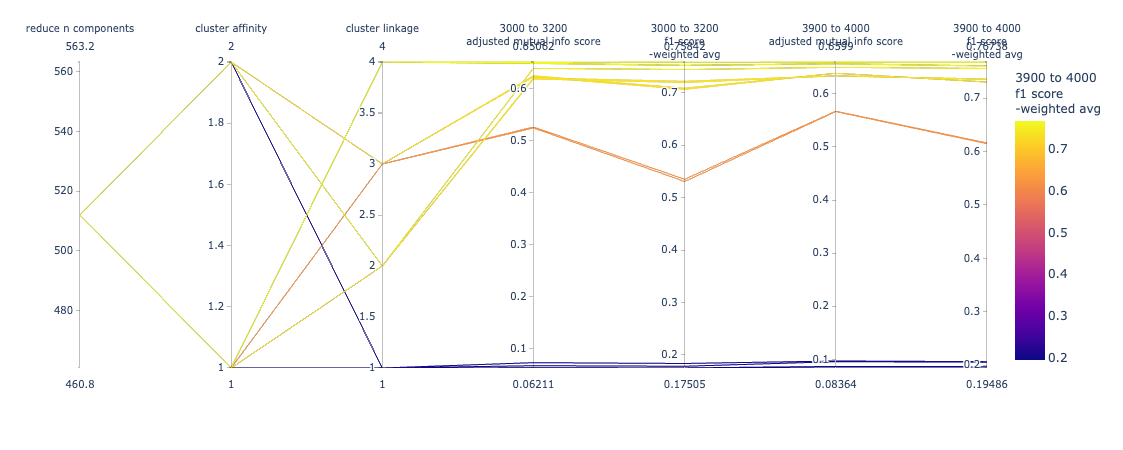

In [199]:
l_cols_plot_raw_ = l_parallel_params + l_parallel_metrics_3k + l_parallel_metrics_4k
l_cols_plot_clean_ = [rename_col_for_display(c) for c in l_cols_plot_raw_]
df_plot_ = (
    df_mlf_clustering_candidates
    [df_mlf_clustering_candidates['metrics.filtered_embeddings-n_rows'] >= 49000]
    [l_cols_plot_raw_]
    .fillna({'params._pipe-reduce__n_components': 512, 'params._pipe-normalize__norm': 'None'})  # for SVD nulls & norm nulls
    .rename(columns={c: rename_col_for_display(c) for c in l_cols_plot_raw_})
    .reset_index(drop=True)
)
# remap cluster linkage so it shows up in plot
col_linkage_clean = 'cluster linkage'
col_affinity_clean = 'cluster affinity'
col_comp_clean = 'reduce n components'

df_plot_[col_linkage_clean] = df_plot_[col_linkage_clean].replace(d_linkage_to_num)
df_plot_[col_affinity_clean] = df_plot_[col_affinity_clean].replace(d_affinity_to_num)
df_plot_[col_comp_clean] = df_plot_[col_comp_clean].astype(int).replace(d_comp_to_num)
print(f"Linkage names:\n  {d_num_to_linkage}")
print(f"Affinity names:\n  {d_num_to_affinity}")
print(f"Component names:\n  {d_num_to_comp}")

# apply filters
# df_plot_ = df_plot_[df_plot_[col_linkage_clean] != d_linkage_to_num['single']].reset_index(drop=True)
df_plot_ = df_plot_[df_plot_[col_comp_clean] != 2].reset_index(drop=True)
print(df_plot_.shape)

df_top_runs = df_plot_.copy()

fig = px.parallel_coordinates(
    df_plot_,
    color=l_cols_plot_clean_[-1],
    # dimensions=l_cols_plot_clean_,
    # labels={},
    # color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=2
)
fig.show()

## Create masks to find top runs

`Ward` linkage (#4) gets the best score followed by `complete` linkage (#2).

Find runs that are above the mean of linkage=2 (complete linkage). Use these params as the primary search space for v0.5.0.

In [202]:
df_top_runs.shape

(18, 8)

In [212]:
display(
    df_top_runs.groupby([col_linkage_clean])[l_cols_plot_clean_[-4:]].mean()
)

,3000 to 3200<br>adjusted mutual info score<br>,3000 to 3200<br>f1 score<br>-weighted avg<br><br>,3900 to 4000<br>adjusted mutual info score<br>,3900 to 4000<br>f1 score<br>-weighted avg<br><br>
cluster linkage,,,,
1,0.065851,0.178087,0.090669,0.201172
2,0.628821,0.732182,0.641946,0.745117
3,0.573904,0.620089,0.602773,0.672569
4,0.649183,0.755045,0.658186,0.763513


In [218]:
c_f1_pt_weighted_3k = 'metrics.primary_topic-3000_to_3200-f1_score-weighted_avg'
c_f1_pt_weighted_4k = 'metrics.primary_topic-3900_to_4000-f1_score-weighted_avg'
mask_top_metrics = (
    (df_mlf_clustering_candidates[c_f1_pt_weighted_3k] >= 0.7) &
    (df_mlf_clustering_candidates[c_f1_pt_weighted_4k] >= 0.7) 
)

print(mask_top_metrics.sum())

42


In [219]:
l_cols_to_drop = [
    'artifact_uri',
    'start_time',
    'end_time',
]

l_cols_to_drop = (
    l_cols_to_drop + 
    [c for c in cols_with_multiple_vals if 'metrics.memory_' in c] +
    [c for c in cols_with_multiple_vals if 'metrics.model_fit' in c] +
    [c for c in cols_with_multiple_vals if 'metrics.optimal_k' in c]
)

In [220]:
df_top_runs_full = (
    df_mlf_clustering_candidates
    [mask_top_metrics]
    .sort_values(by=l_cols_plot_raw_[::-1][:-2], ascending=False)
    [sorted(cols_with_multiple_vals)]
    .drop(l_cols_to_drop, axis=1)
)
df_top_runs_full.shape

(42, 215)

In [221]:
l_parallel_params = [
    # 'metrics.filtered_embeddings-n_rows',  # Might not be a parameter to tune anymore (n_minimumn # of posts in subreddit)
    'params._pipe-normalize__norm', 
    'params._pipe-reduce__n_components',
    'params._pipe-cluster__affinity',
    'params._pipe-cluster__linkage',

]

for c_ in l_parallel_params:
    display(
        value_counts_and_pcts(
            df_top_runs_full,
            [c_]
        )
    )

,count,percent,cumulative_percent
params._pipe-normalize__norm,,,
null,33,78.6%,78.6%
l2,9,21.4%,100.0%


,count,percent,cumulative_percent
params._pipe-reduce__n_components,,,
null,42,100.0%,100.0%


,count,percent,cumulative_percent
params._pipe-cluster__affinity,,,
euclidean,26,61.9%,61.9%
cosine,16,38.1%,100.0%


,count,percent,cumulative_percent
params._pipe-cluster__linkage,,,
ward,18,42.9%,42.9%
complete,16,38.1%,81.0%
average,8,19.0%,100.0%


In [222]:
value_counts_and_pcts(
    df_top_runs_full,
    l_parallel_params
)

### Parameters to explore for v0.5.0

NOTE: First we need to fix the `reduce` step!  We should test `n_components=128` instead of the weird failed state right now that reduces to `2` components


`ward`:

```bash
# ward-related jobs
!cd $path_djb_repo && python -m $file_clustering_py --multirun \
    --config-name $config_name \
    "clustering_algo.model_kwargs.linkage='ward'" \
    "clustering_algo.model_kwargs.affinity='euclidean'" \
    "filter_embeddings.filter_subreddits.minimum_column_value=range(3, 5, 1)" \
    "pipeline_config.normalize.add_step=choice(false, true)" \
    "pipeline_config.reduce.add_step=choice(false, true)"
```

`non-ward` affinities:
```bash
# non-ward linkages
#  We set normalize.add_step=false because that's only used for Ward,
#  where normalize+euclidean = cosine distance

!cd $path_djb_repo && python -m $file_clustering_py --multirun \
    --config-name $config_name \
    "clustering_algo.model_kwargs.linkage=choice('complete', 'average')" \
    "clustering_algo.model_kwargs.affinity=choice('cosine', 'euclidean')" \
    "filter_embeddings.filter_subreddits.minimum_column_value=range(3, 5, 1)" \
    "pipeline_config.reduce.add_step=choice(false, true)" \
    "pipeline_config.normalize.add_step=false"
```

In [237]:
(
    df_top_runs_full.fillna('None')
    .groupby(l_parallel_params)
    [c_f1_pt_weighted_3k, c_f1_pt_weighted_4k]
    .mean()
    .sort_values(by=c_f1_pt_weighted_4k, ascending=False)
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



metrics.primary_topic-3000_to_3200-f1_score-weighted_avg  metrics.primary_topic-3900_to_4000-f1_score-weighted_avg
params._pipe-normalize__norm params._pipe-reduce__n_components params._pipe-cluster__affinity params._pipe-cluster__linkage                                                                                                                    
l2                           None                              euclidean                      ward                                                                           0.758708                                                  0.768533
None                         None                              euclidean                      ward                                                                           0.753358                                                  0.761316
                                                               cosine                         complete                                                                       0.746465                                                  0.758403
                                                               euclidean                      complete                                                                       0.725030                                                  0.739520
                                                               cosine                         average                                                                        0.717640                                                  0.738332

In [238]:
(
    df_mlf_clustering_candidates.fillna('None')
    .groupby(l_parallel_params)
    [c_f1_pt_weighted_3k, c_f1_pt_weighted_4k]
    .mean()
    .sort_values(by=c_f1_pt_weighted_4k, ascending=False)
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



metrics.primary_topic-3000_to_3200-f1_score-weighted_avg  metrics.primary_topic-3900_to_4000-f1_score-weighted_avg
params._pipe-normalize__norm params._pipe-reduce__n_components params._pipe-cluster__affinity params._pipe-cluster__linkage                                                                                                                    
l2                           None                              euclidean                      ward                                                                           0.758708                                                  0.768533
None                         None                              euclidean                      ward                                                                           0.753358                                                  0.761316
                                                               cosine                         complete                                                                       0.746465                                                  0.758403
                                                               euclidean                      complete                                                                       0.725030                                                  0.739520
                                                               cosine                         average                                                                        0.717640                                                  0.738332
                                                               euclidean                      average                                                                        0.579612                                                  0.636235
                             2                                 euclidean                      ward                                                                           0.384741                                                  0.400086
                                                                                              complete                                                                       0.380544                                                  0.395155
                                                                                              average                                                                        0.379068                                                  0.392661
l2                           2                                 euclidean                      ward                                                                           0.363938                                                  0.380353
None                         2                                 cosine                         complete                                                                       0.323966                                                  0.342781
                                                                                              average                                                                        0.321937                                                  0.341154
                                                                                              single                                                                         0.321788                                                  0.340555
                                                               euclidean                      single                                                                         0.199343                                                  0.221235
                             None                              cosine                         single                                                                         0.191310                                                  0.217834
                                             